# 🏺 Unsupervised Motif Clustering in Pottery Decorations extended with additional metadata

### UMAP + DBSCAN Pipeline for Visual Pattern Analysis  
#### by [Your Name] | [Your Institution or Project Name]  
🗓️ June 2025

## 📄 Abstract

This notebook demonstrates a full pipeline for analyzing decorative patterns on archaeological pottery using unsupervised machine learning.

The goal is to explore the visual clustering of motifs from Late Neolithic to Early Bronze Age in Eastern Europe, with a workflow that supports both synthetic and real datasets. The pipeline includes:

- Image feature extraction
- Dimensionality reduction with UMAP
- Density-based clustering with DBSCAN
- Rich visualizations including thumbnails and cluster-wise motif distribution

This approach can aid in detecting regional styles, workshop patterns, or typological innovation across time and space.

🔍 The workflow is modular and extendable — suitable for rapid testing or full-scale digital analysis with curated image datasets.


### 🔧 Environment Setup

We define and install all required packages using Conda and pip. The environment includes:

- `numpy`, `pandas`, `scikit-learn` for numerical operations and ML
- `Pillow`, `opencv-python` for image processing
- `umap-learn`, `dbscan` for dimensionality reduction and clustering
- `matplotlib`, `seaborn` for plotting

This environment ensures cross-platform reproducibility.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

import torch
import clip
import umap

### 🧰 Dataset Preparation

We assume a structured folder of images with associated metadata (e.g. motif style, culture, filenames). This can be generated manually or imported from digital repositories or field documentation.

Each image represents a pottery decoration (rim, body, handle, etc.). Metadata is stored in a CSV format for easy manipulation and merging with results.


In [2]:
# === Paths ===
DATA_DIR = "synthetic_motifs/augmented"
IMG_DIR = DATA_DIR
METADATA_CSV = os.path.join(DATA_DIR, "augmented_metadata.csv")
OUTPUT_FEATURES_CSV = os.path.join(DATA_DIR, "features_with_clusters.csv")

In [3]:
# === Load metadata
df = pd.read_csv(METADATA_CSV)
image_paths = [os.path.join(IMG_DIR, fname) for fname in df["image_id"]]

In [4]:
df

,image_id,original_image,motif_style,decoration_type,vessel_part,vessel_type,culture,chronological_phase,region,site,source,annotator,comments
0,zigzag_000_aug0.png,zigzag_000.png,zigzag,incised,body,bowl,Mierzanowice,2300–1800 BCE,Central Poland,VirtualSite_004,synthetic_generator,auto,synthetic sample
1,zigzag_000_aug1.png,zigzag_000.png,zigzag,incised,rim,beaker,Mierzanowice,2300–1800 BCE,Central Poland,VirtualSite_005,synthetic_generator,auto,synthetic sample
2,zigzag_000_aug2.png,zigzag_000.png,zigzag,incised,shoulder,bowl,Mierzanowice,2300–1800 BCE,Central Poland,VirtualSite_003,synthetic_generator,auto,synthetic sample
3,zigzag_000_aug3.png,zigzag_000.png,zigzag,incised,base,amphora,Mierzanowice,2300–1800 BCE,Central Poland,VirtualSite_004,synthetic_generator,auto,synthetic sample
4,zigzag_000_aug4.png,zigzag_000.png,zigzag,incised,base,beaker,Mierzanowice,2300–1800 BCE,Central Poland,VirtualSite_002,synthetic_generator,auto,synthetic sample
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,comb_009_aug5.png,comb_009.png,comb,corded,shoulder,bowl,Narva,4200–3200 BCE,Baltic Coast,VirtualSite_001,synthetic_generator,auto,synthetic sample
996,comb_009_aug6.png,comb_009.png,comb,corded,body,bowl,Narva,4200–3200 BCE,Baltic Coast,VirtualSite_005,synthetic_generator,auto,synthetic sample
997,comb_009_aug7.png,comb_009.png,comb,corded,body,amphora,Narva,4200–3200 BCE,Baltic Coast,VirtualSite_005,synthetic_generator,auto,synthetic sample
998,comb_009_aug8.png,comb_009.png,comb,corded,base,bowl,Narva,4200–3200 BCE,Baltic Coast,VirtualSite_004,synthetic_generator,auto,synthetic sample


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             1000 non-null   object
 1   original_image       1000 non-null   object
 2   motif_style          1000 non-null   object
 3   decoration_type      1000 non-null   object
 4   vessel_part          1000 non-null   object
 5   vessel_type          1000 non-null   object
 6   culture              1000 non-null   object
 7   chronological_phase  1000 non-null   object
 8   region               1000 non-null   object
 9   site                 1000 non-null   object
 10  source               1000 non-null   object
 11  annotator            1000 non-null   object
 12  comments             1000 non-null   object
dtypes: object(13)
memory usage: 101.7+ KB


In [6]:
df.describe()

,image_id,original_image,motif_style,decoration_type,vessel_part,vessel_type,culture,chronological_phase,region,site,source,annotator,comments
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,100,10,4,5,4,10,10,10,5,1,1,1
top,comb_009_aug9.png,zigzag_000.png,zigzag,incised,rim,amphora,Mierzanowice,2300–1800 BCE,Central Poland,VirtualSite_005,synthetic_generator,auto,synthetic sample
freq,1,10,100,700,215,274,100,100,100,207,1000,1000,1000


### 🧼 Preprocessing and Feature Extraction

Images are resized and flattened into vectors. This basic feature representation can be replaced with:

- HOG or SIFT features
- Deep learning embeddings (e.g. CNN-based)
- Texture descriptors or shape descriptors

The current pipeline uses pixel intensity vectors to maintain transparency and simplicity.


In [7]:
# === CLIP Model Setup (for Embeddings)
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths, desc="Embedding images"):
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = clip_model.encode_image(image)
                features.append(feature.cpu().numpy().flatten())
        except Exception as e:
            print(f"Failed on {path}: {e}")
            features.append(np.zeros(512))  # fallback
    return np.vstack(features)

In [8]:
# === Extract CLIP Embeddings
X = extract_features(image_paths)

Embedding images: 100%|██████████| 1000/1000 [02:37<00:00,  6.36it/s]


In [9]:
X.shape

(1000, 512)

In [10]:
columns_to_encode = ["motif_style", "decoration_type", "vessel_part", "vessel_type", "culture"]

In [11]:
df_processed = df.copy()
mlb = MultiLabelBinarizer()
encoded_parts = []

for col in columns_to_encode:
    encoded = pd.DataFrame(mlb.fit_transform(df_processed[col]), columns=[f"{col}_{cls}" for cls in mlb.classes_])
    encoded_parts.append(encoded)

len(encoded_parts)
encoded_parts[0].head()

,motif_style__,motif_style_a,motif_style_b,motif_style_c,motif_style_d,motif_style_e,motif_style_g,motif_style_h,motif_style_i,motif_style_l,motif_style_m,motif_style_n,motif_style_o,motif_style_p,motif_style_r,motif_style_s,motif_style_t,motif_style_v,motif_style_w,motif_style_z
0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [12]:
df_processed = df_processed.drop(columns=columns_to_encode)

for part in encoded_parts:
    print(part.shape)
    # Concatenate the processed DataFrame with the encoded parts
    df_processed = pd.concat([df_processed, part], axis=1)

df_processed.head()

(1000, 20)
(1000, 12)
(1000, 16)
(1000, 12)
(1000, 35)


,image_id,original_image,chronological_phase,region,site,source,annotator,comments,motif_style__,motif_style_a,...,culture_o,culture_p,culture_r,culture_s,culture_t,culture_u,culture_v,culture_w,culture_z,culture_ł
0,zigzag_000_aug0.png,zigzag_000.png,2300–1800 BCE,Central Poland,VirtualSite_004,synthetic_generator,auto,synthetic sample,0,1,...,1,0,1,0,0,0,0,1,1,0
1,zigzag_000_aug1.png,zigzag_000.png,2300–1800 BCE,Central Poland,VirtualSite_005,synthetic_generator,auto,synthetic sample,0,1,...,1,0,1,0,0,0,0,1,1,0
2,zigzag_000_aug2.png,zigzag_000.png,2300–1800 BCE,Central Poland,VirtualSite_003,synthetic_generator,auto,synthetic sample,0,1,...,1,0,1,0,0,0,0,1,1,0
3,zigzag_000_aug3.png,zigzag_000.png,2300–1800 BCE,Central Poland,VirtualSite_004,synthetic_generator,auto,synthetic sample,0,1,...,1,0,1,0,0,0,0,1,1,0
4,zigzag_000_aug4.png,zigzag_000.png,2300–1800 BCE,Central Poland,VirtualSite_002,synthetic_generator,auto,synthetic sample,0,1,...,1,0,1,0,0,0,0,1,1,0


In [13]:
# Split 'chronological_phase' into 'phase_start' and 'phase_end' columns
def extract_start_end(phase_str):
    # Example: "2300–1800 BCE"
    if isinstance(phase_str, str):
        parts = phase_str.replace(" ", "").replace("BCE", "").split("–")
        if len(parts) == 2:
            try:
                start = int(parts[0])
                end = int(parts[1])
                return start, end
            except ValueError:
                return None, None
    return None, None

df_processed["phase_start"], df_processed["phase_end"] = zip(*df_processed["chronological_phase"].map(extract_start_end))
df_processed[["chronological_phase", "phase_start", "phase_end"]].head()

,chronological_phase,phase_start,phase_end
0,2300–1800 BCE,2300,1800
1,2300–1800 BCE,2300,1800
2,2300–1800 BCE,2300,1800
3,2300–1800 BCE,2300,1800
4,2300–1800 BCE,2300,1800


In [14]:
df_final = df_processed.drop(columns=["image_id", "original_image", "region", "site", "source", "annotator", "comments", "chronological_phase"])

df_final.head()

,motif_style__,motif_style_a,motif_style_b,motif_style_c,motif_style_d,motif_style_e,motif_style_g,motif_style_h,motif_style_i,motif_style_l,...,culture_r,culture_s,culture_t,culture_u,culture_v,culture_w,culture_z,culture_ł,phase_start,phase_end
0,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,2300,1800
1,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,2300,1800
2,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,2300,1800
3,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,2300,1800
4,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,1,0,2300,1800


### 📉 Dimensionality Reduction with UMAP

UMAP projects high-dimensional image vectors into 2D for visualization. It preserves both local and global structure better than PCA or t-SNE, making it ideal for visual clustering of stylistic motifs.

Adjustable parameters:
- `n_neighbors`: local focus vs. global layout
- `min_dist`: cluster compactness


In [15]:
# === UMAP Dimensionality Reduction
print("Reducing dimensionality with UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(X)

Reducing dimensionality with UMAP...


c:\Users\macie\miniconda3\envs\inb-poc\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\macie\miniconda3\envs\inb-poc\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
X_umap

array([[15.772268 , 12.503424 ],
       [16.009573 , 12.475592 ],
       [16.989227 , 14.145103 ],
       ...,
       [15.5457   ,  5.760022 ],
       [ 1.5263678, 13.145992 ],
       [ 1.3479054, 12.807245 ]], shape=(1000, 2), dtype=float32)

In [17]:
df_final["umap_x"] = X_umap[:, 0]
df_final["umap_y"] = X_umap[:, 1]
df["umap_x"] = X_umap[:, 0]
df["umap_y"] = X_umap[:, 1]

In [18]:
scaler = StandardScaler()
df_final = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)
df_final.head()

,motif_style__,motif_style_a,motif_style_b,motif_style_c,motif_style_d,motif_style_e,motif_style_g,motif_style_h,motif_style_i,motif_style_l,...,culture_t,culture_u,culture_v,culture_w,culture_z,culture_ł,phase_start,phase_end,umap_x,umap_y
0,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.0,-0.654654,1.224745,-0.654654,...,-0.816497,-1.0,-0.333333,3.0,2.0,-0.333333,-0.32691,-0.246183,0.967799,0.893278
1,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.0,-0.654654,1.224745,-0.654654,...,-0.816497,-1.0,-0.333333,3.0,2.0,-0.333333,-0.32691,-0.246183,0.999840,0.889491
2,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.0,-0.654654,1.224745,-0.654654,...,-0.816497,-1.0,-0.333333,3.0,2.0,-0.333333,-0.32691,-0.246183,1.132118,1.116638
3,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.0,-0.654654,1.224745,-0.654654,...,-0.816497,-1.0,-0.333333,3.0,2.0,-0.333333,-0.32691,-0.246183,1.004618,0.911255
4,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.0,-0.654654,1.224745,-0.654654,...,-0.816497,-1.0,-0.333333,3.0,2.0,-0.333333,-0.32691,-0.246183,-0.638984,1.295301


In [19]:
corr_matrix = df_final.corr()
corr_matrix

,motif_style__,motif_style_a,motif_style_b,motif_style_c,motif_style_d,motif_style_e,motif_style_g,motif_style_h,motif_style_i,motif_style_l,...,culture_t,culture_u,culture_v,culture_w,culture_z,culture_ł,phase_start,phase_end,umap_x,umap_y
motif_style__,1.000000,0.327327,-0.166667,0.102062,-0.250000,0.408248,-0.166667,0.218218,0.612372,0.763763,...,0.102062,5.762057e-17,-0.166667,-0.166667,-0.250000,-0.166667,0.040864,0.092319,0.022172,-0.318944
motif_style_a,0.327327,1.000000,-0.509175,-0.356348,-0.218218,-0.089087,0.218218,-0.047619,0.534522,0.428571,...,0.534522,6.546537e-01,-0.509175,0.218218,-0.218218,0.218218,-0.321019,-0.188025,0.065892,-0.362103
motif_style_b,-0.166667,-0.509175,1.000000,0.408248,-0.166667,-0.408248,-0.111111,-0.218218,-0.272166,-0.218218,...,-0.272166,-3.333333e-01,1.000000,-0.111111,-0.166667,-0.111111,0.630470,0.492366,0.125334,0.091778
motif_style_c,0.102062,-0.356348,0.408248,1.000000,-0.408248,-0.166667,-0.272166,0.356348,-0.250000,-0.089087,...,-0.666667,3.119727e-16,0.408248,-0.272166,0.102062,-0.272166,0.543375,0.477393,0.162590,0.025453
motif_style_d,-0.250000,-0.218218,-0.166667,-0.408248,1.000000,0.408248,-0.166667,-0.327327,-0.408248,-0.327327,...,0.102062,2.793321e-16,-0.166667,-0.166667,-0.250000,-0.166667,-0.280209,-0.369274,-0.220423,0.229633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
culture_ł,-0.166667,0.218218,-0.111111,-0.272166,-0.166667,0.272166,-0.111111,-0.218218,-0.272166,-0.218218,...,0.408248,3.333333e-01,-0.111111,-0.111111,-0.166667,1.000000,0.163455,0.246183,0.251502,-0.022968
phase_start,0.040864,-0.321019,0.630470,0.543375,-0.280209,-0.257388,-0.108970,-0.061147,-0.290753,-0.239491,...,-0.552908,-1.401043e-01,0.630470,-0.108970,-0.280209,0.163455,1.000000,0.968631,0.130148,-0.059047
phase_end,0.092319,-0.188025,0.492366,0.477393,-0.369274,-0.276385,-0.082061,-0.107443,-0.150756,-0.107443,...,-0.502519,-2.461830e-02,0.492366,-0.082061,-0.307729,0.246183,0.968631,1.000000,0.068066,-0.173596
umap_x,0.022172,0.065892,0.125334,0.162590,-0.220423,0.085530,0.180502,0.111180,-0.136657,-0.264259,...,-0.041349,-6.567566e-02,0.125334,0.180502,0.249753,0.251502,0.130148,0.068066,1.000000,-0.142683


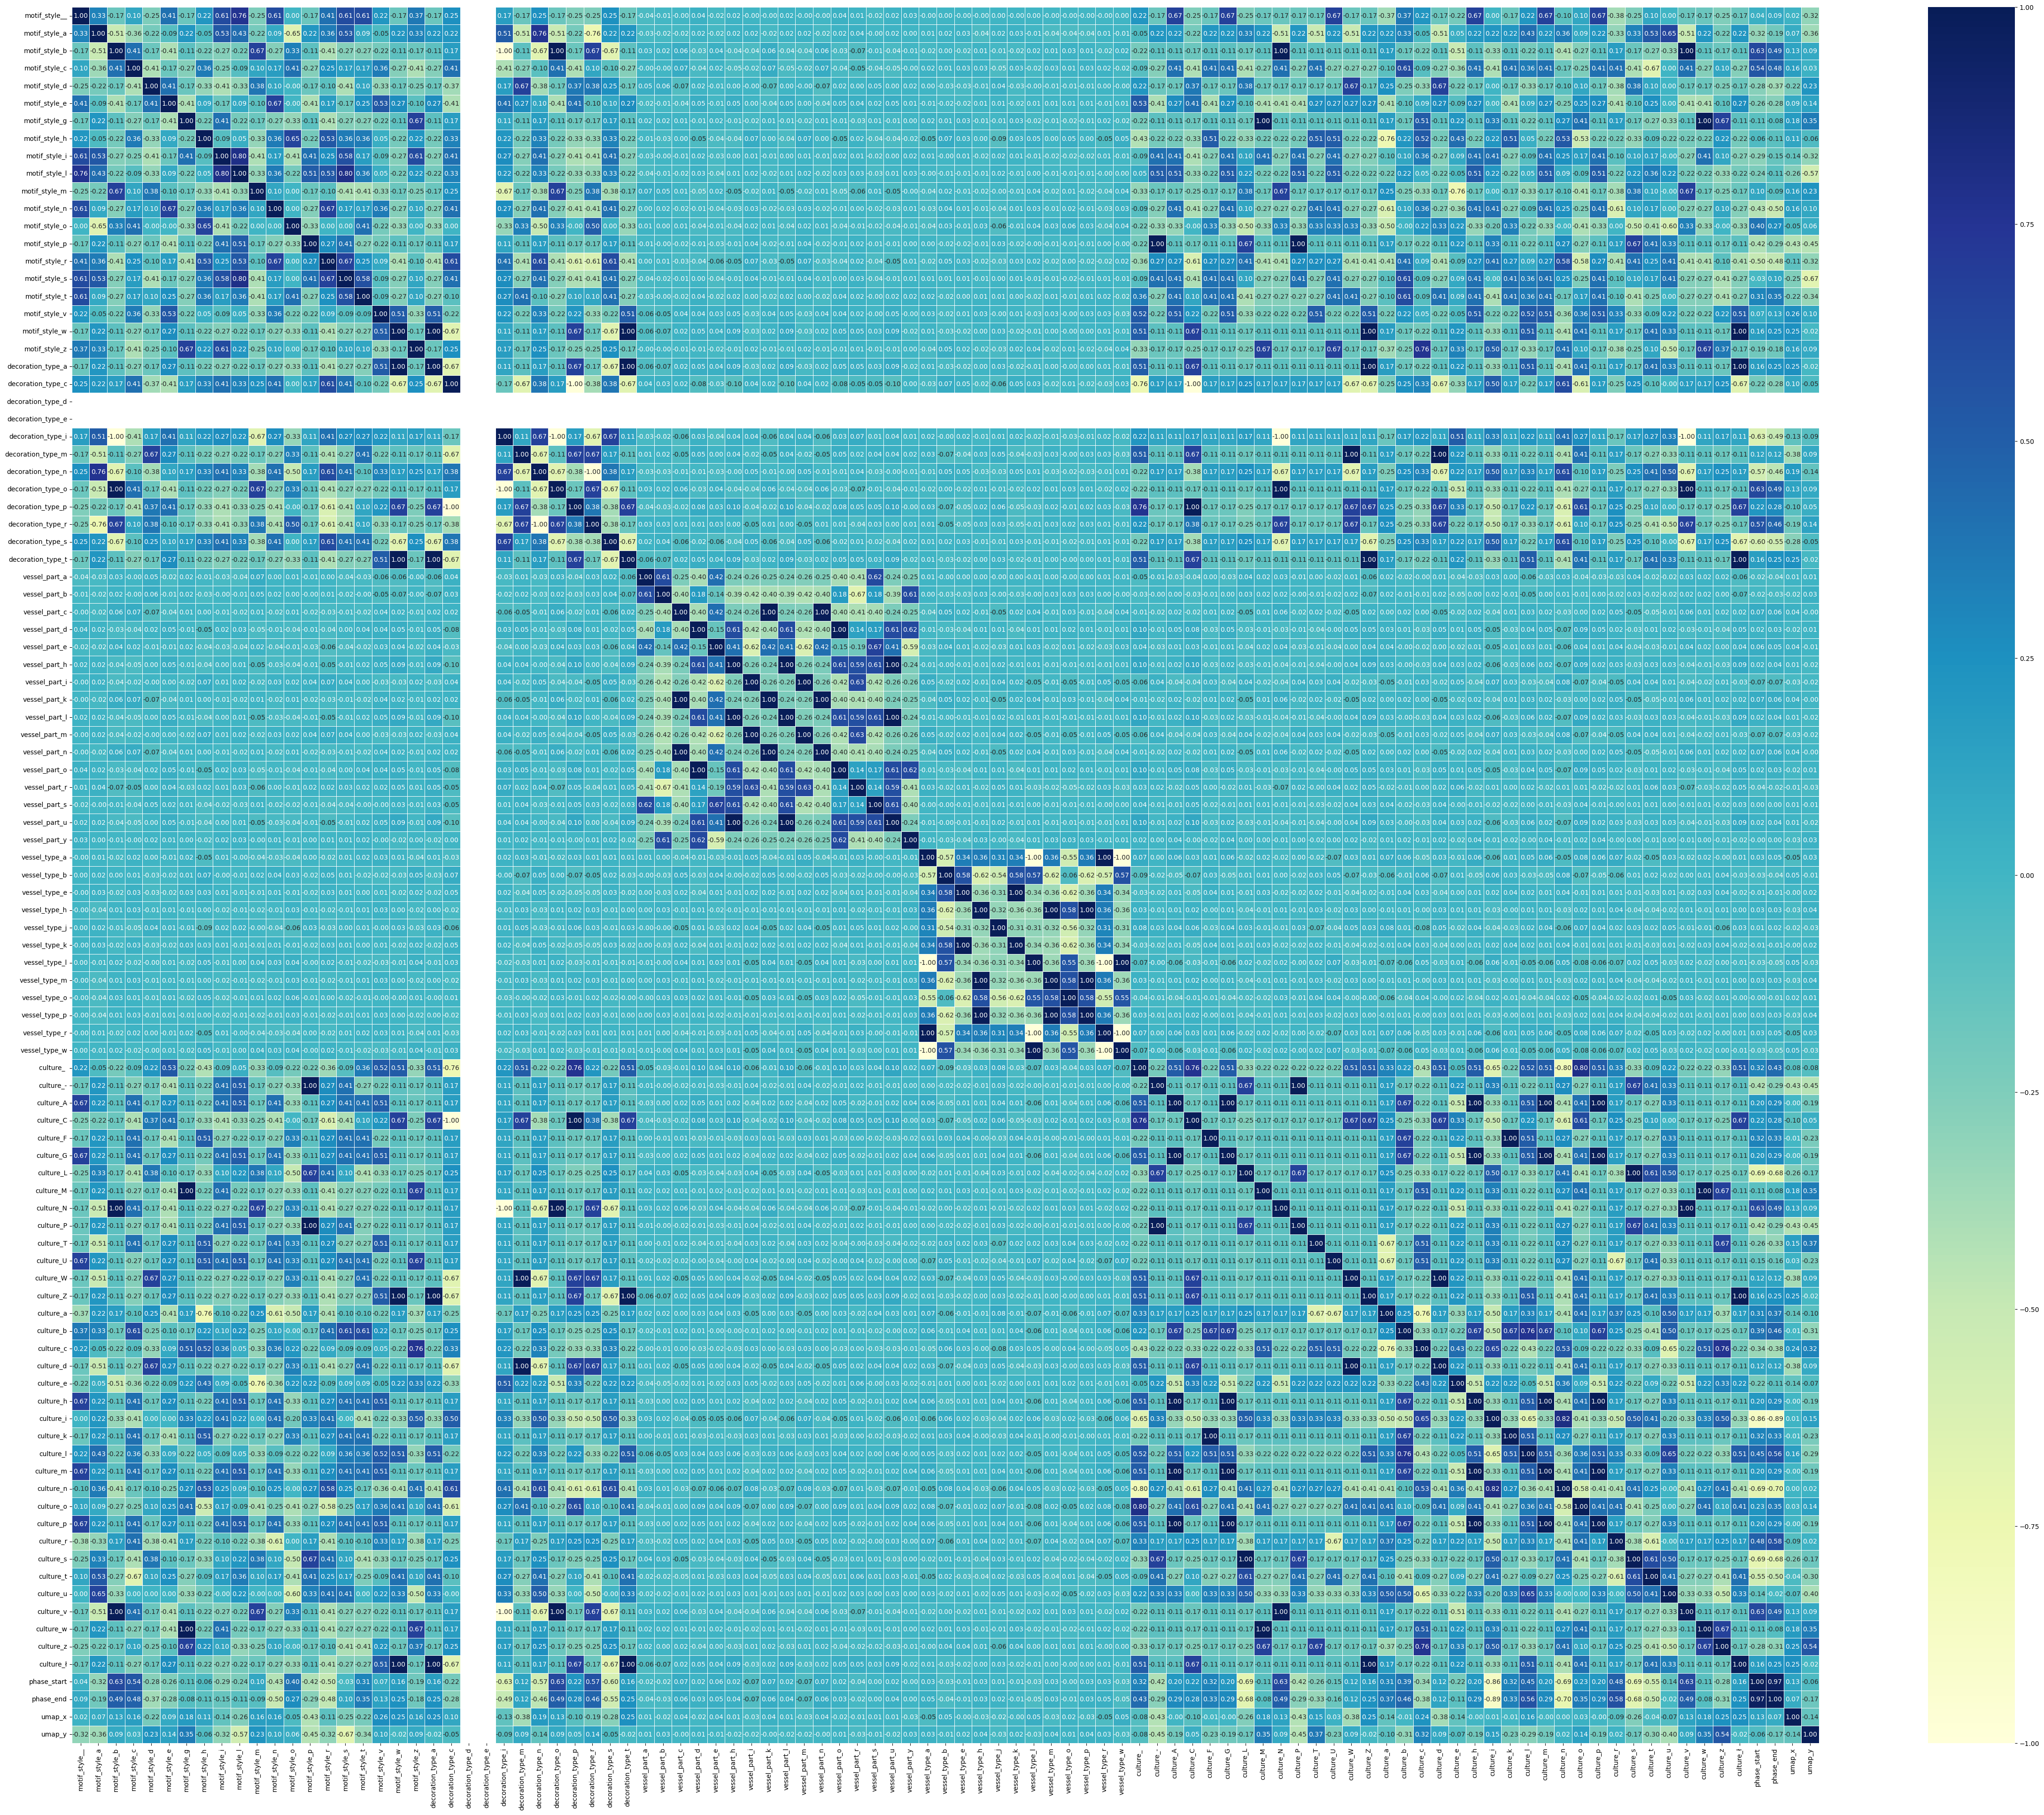

In [ ]:
plt.figure(figsize=(60, 48))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt=".2f",
            cmap="YlGnBu")
plt.savefig(os.path.join(DATA_DIR, "correlation_matrix.png"), bbox_inches='tight', dpi=300)
plt.show()

### 🧠 Clustering with DBSCAN

DBSCAN is a density-based clustering algorithm, well-suited for irregular motif clusters. It automatically detects outliers and doesn’t require specifying the number of clusters.

Parameters:
- `eps`: defines neighborhood radius
- `min_samples`: minimum points to form a cluster

The result: labels assigned to each image, including `-1` for noise/outliers.


In [38]:
bandwidth = estimate_bandwidth(df_final, quantile=0.05)
bandwidth

np.float64(8.19049250620359)

In [39]:
model = MeanShift(bandwidth=bandwidth)
model.fit(df_final)


,bandwidth,np.float64(8.19049250620359)
,seeds,None
,bin_seeding,False
,min_bin_freq,1
,cluster_all,True
,n_jobs,None
,max_iter,300


In [40]:
df['cluster'] = model.labels_
df_final['cluster'] = model.labels_
df['cluster'].value_counts()

cluster
5    100
8    100
6    100
2    100
9    100
1    100
0    100
3    100
4    100
7    100
Name: count, dtype: int64

In [41]:
df_final

,motif_style__,motif_style_a,motif_style_b,motif_style_c,motif_style_d,motif_style_e,motif_style_g,motif_style_h,motif_style_i,motif_style_l,...,culture_u,culture_v,culture_w,culture_z,culture_ł,phase_start,phase_end,umap_x,umap_y,cluster
0,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.000000,-0.654654,1.224745,-0.654654,...,-1.0,-0.333333,3.000000,2.0,-0.333333,-0.326910,-0.246183,0.967799,0.893278,5
1,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.000000,-0.654654,1.224745,-0.654654,...,-1.0,-0.333333,3.000000,2.0,-0.333333,-0.326910,-0.246183,0.999840,0.889491,5
2,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.000000,-0.654654,1.224745,-0.654654,...,-1.0,-0.333333,3.000000,2.0,-0.333333,-0.326910,-0.246183,1.132118,1.116638,5
3,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.000000,-0.654654,1.224745,-0.654654,...,-1.0,-0.333333,3.000000,2.0,-0.333333,-0.326910,-0.246183,1.004618,0.911255,5
4,-0.5,0.654654,-0.333333,-0.816497,-0.5,-1.224745,3.000000,-0.654654,1.224745,-0.654654,...,-1.0,-0.333333,3.000000,2.0,-0.333333,-0.326910,-0.246183,-0.638984,1.295301,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.5,-1.527525,3.000000,1.224745,-0.5,-1.224745,-0.333333,-0.654654,-0.816497,-0.654654,...,-1.0,3.000000,-0.333333,-0.5,-0.333333,1.891409,1.477098,1.058596,-0.075190,7
996,-0.5,-1.527525,3.000000,1.224745,-0.5,-1.224745,-0.333333,-0.654654,-0.816497,-0.654654,...,-1.0,3.000000,-0.333333,-0.5,-0.333333,1.891409,1.477098,1.003010,-0.023659,7
997,-0.5,-1.527525,3.000000,1.224745,-0.5,-1.224745,-0.333333,-0.654654,-0.816497,-0.654654,...,-1.0,3.000000,-0.333333,-0.5,-0.333333,1.891409,1.477098,0.937206,-0.024203,7
998,-0.5,-1.527525,3.000000,1.224745,-0.5,-1.224745,-0.333333,-0.654654,-0.816497,-0.654654,...,-1.0,3.000000,-0.333333,-0.5,-0.333333,1.891409,1.477098,-0.955746,0.980703,7


### 🖼️ UMAP Plot (No Thumbnails)

Each data point is represented in 2D using UMAP projection, where relative positioning reflects visual similarity in decoration motifs.

Points are colored by their motif style to allow visual evaluation of cluster separability.

This plot gives a compact, human-readable overview of the decorative space and how stylistic classes overlap or separate based on feature geometry.


In [ ]:
# === UMAP Cluster Plot
def plot_umap_clusters(df, label_column="cluster", title="UMAP Clustering", save_path=os.path.join(DATA_DIR, "umap_clusters.png")):
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("hsv", df[label_column].nunique())

    sns.scatterplot(
        x="umap_x", y="umap_y",
        hue=label_column,
        data=df,
        palette=palette,
        legend="full",
        alpha=0.8,
        s=60,
        edgecolor='k'
    )

    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title=label_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

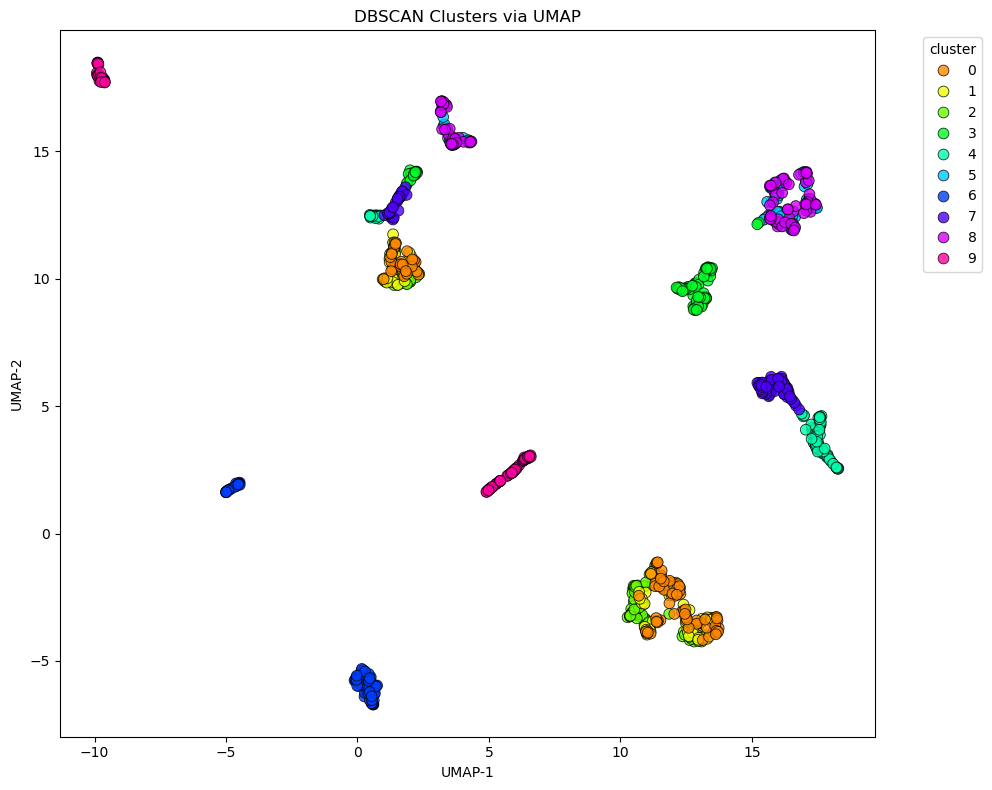

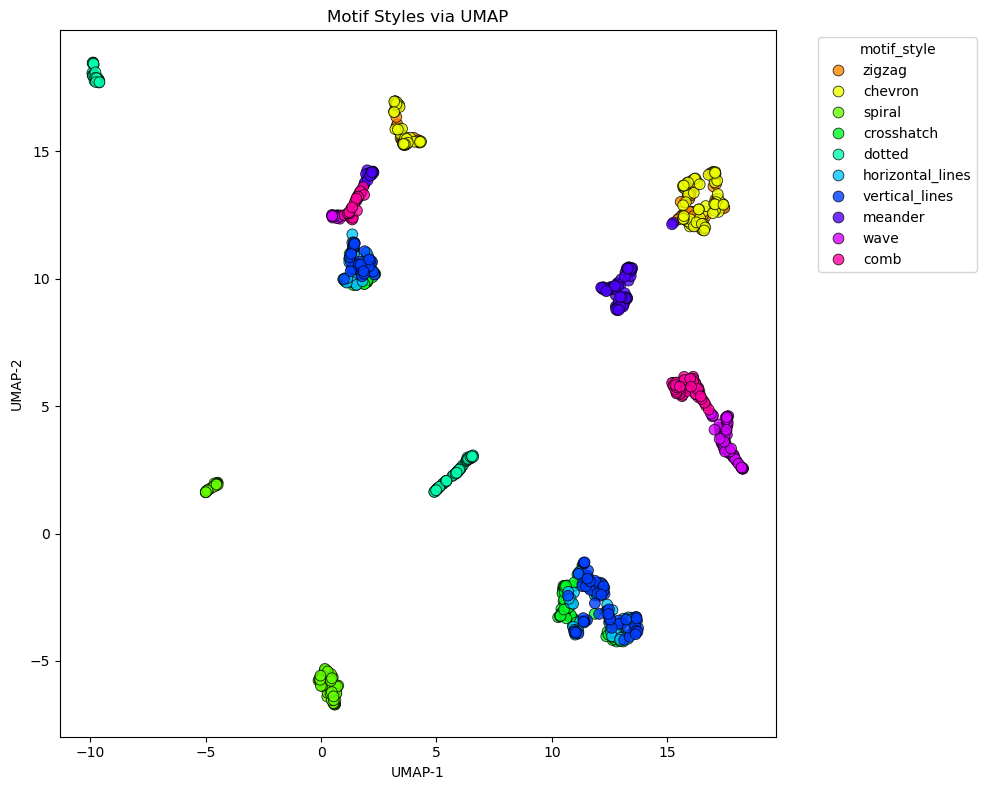

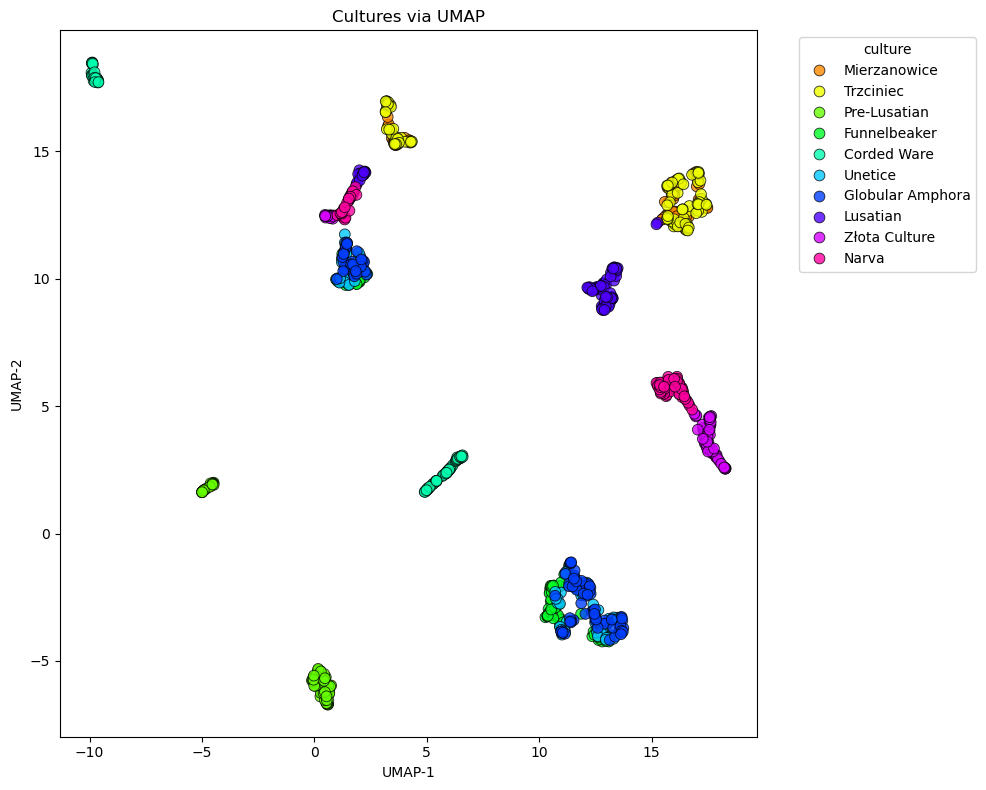

In [ ]:
# === Run visualization
plot_umap_clusters(df, label_column="cluster", title="DBSCAN Clusters via UMAP")
plot_umap_clusters(df, label_column="motif_style", title="Motif Styles via UMAP", save_path=os.path.join(DATA_DIR, "umap_motifs.png"))
plot_umap_clusters(df, label_column="culture", title="Cultures via UMAP", save_path="umap_cultures.png")

In [ ]:

def plot_umap_per_cluster_grid(df,
                                cluster_col="cluster",
                                style_col="motif_style",
                                x_col="umap_x",
                                y_col="umap_y",
                                save_path=os.path.join(DATA_DIR, "umap_clusters_grid_styled_legend.png"),
                                max_cols=4):
    unique_clusters = sorted(df[cluster_col].dropna().unique())
    unique_styles = sorted(df[style_col].dropna().unique())
    num_clusters = len(unique_clusters)

    cols = min(max_cols, num_clusters)
    rows = math.ceil(num_clusters / cols)

    # Consistent color palette
    palette = sns.color_palette("tab10", len(unique_styles))
    style_to_color = dict(zip(unique_styles, palette))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for idx, cluster_id in enumerate(unique_clusters):
        ax = axes[idx]
        cluster_df = df[df[cluster_col] == cluster_id]

        sns.scatterplot(
            data=cluster_df,
            x=x_col, y=y_col,
            hue=style_col,
            palette=style_to_color,
            ax=ax,
            s=40,
            alpha=0.9,
            linewidth=0.3,
            edgecolor="k",
            legend=False
        )

        ax.set_title(f"Cluster {cluster_id}", fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(len(unique_clusters), len(axes)):
        axes[j].axis("off")

    # Build legend handles directly from palette mapping
    legend_handles = [
        mpatches.Patch(color=style_to_color[style], label=style)
        for style in unique_styles
    ]

    fig.legend(
        handles=legend_handles,
        title=style_col,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=min(len(unique_styles), 5),
        fontsize=10,
        title_fontsize=11,
        frameon=False
    )

    fig.suptitle("UMAP Clusters Colored by Motif Style", fontsize=16)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

### 📊 Cluster-wise Motif Style Distribution

Each detected cluster is visualized separately. Points are colored by their motif style (e.g. incised lines, comb stamp, zigzag).

This lets you:
- Evaluate motif diversity within clusters
- Spot potential style overlaps or blends


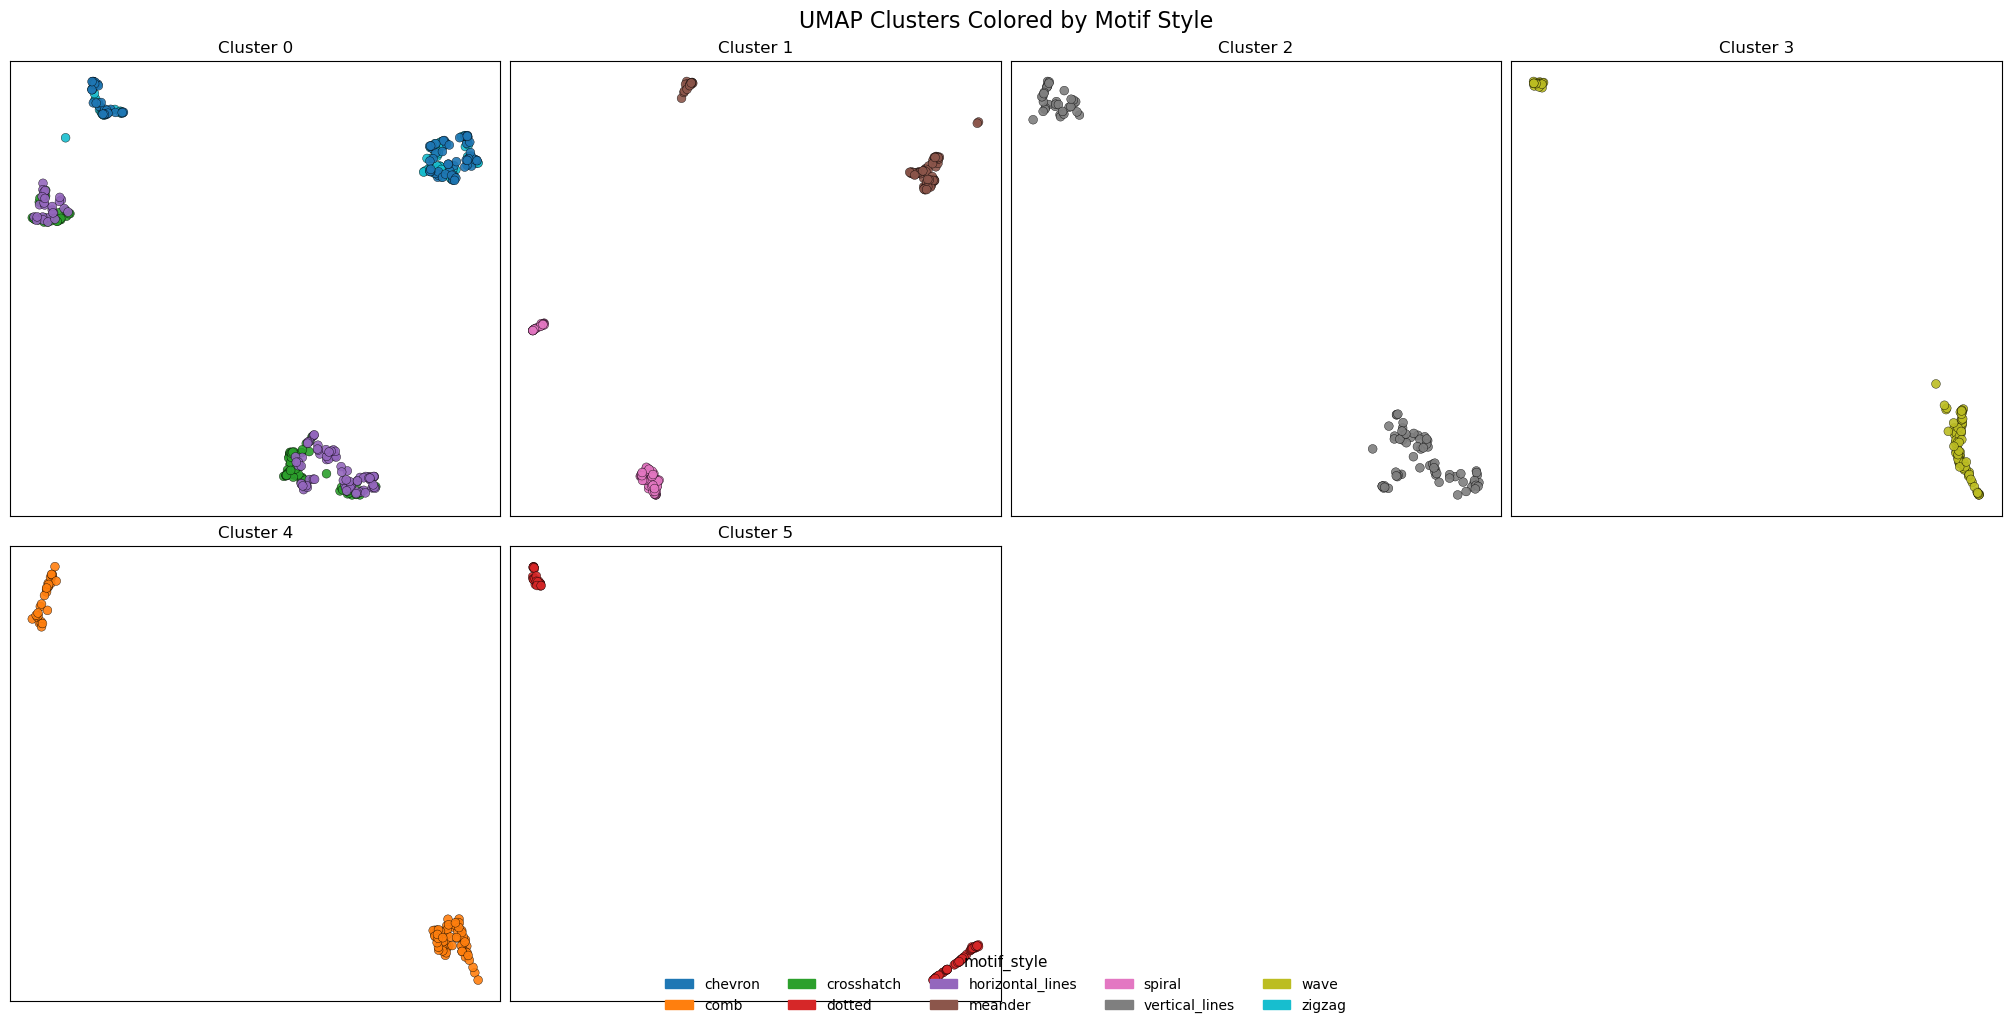

In [28]:
plot_umap_per_cluster_grid(df)

### 📊 Cluster-wise Motif Style Distribution

Each detected cluster is visualized separately. Points are colored by their motif style (e.g. incised lines, comb stamp, zigzag).

This lets you:
- Evaluate motif diversity within clusters
- Spot potential style overlaps or blends


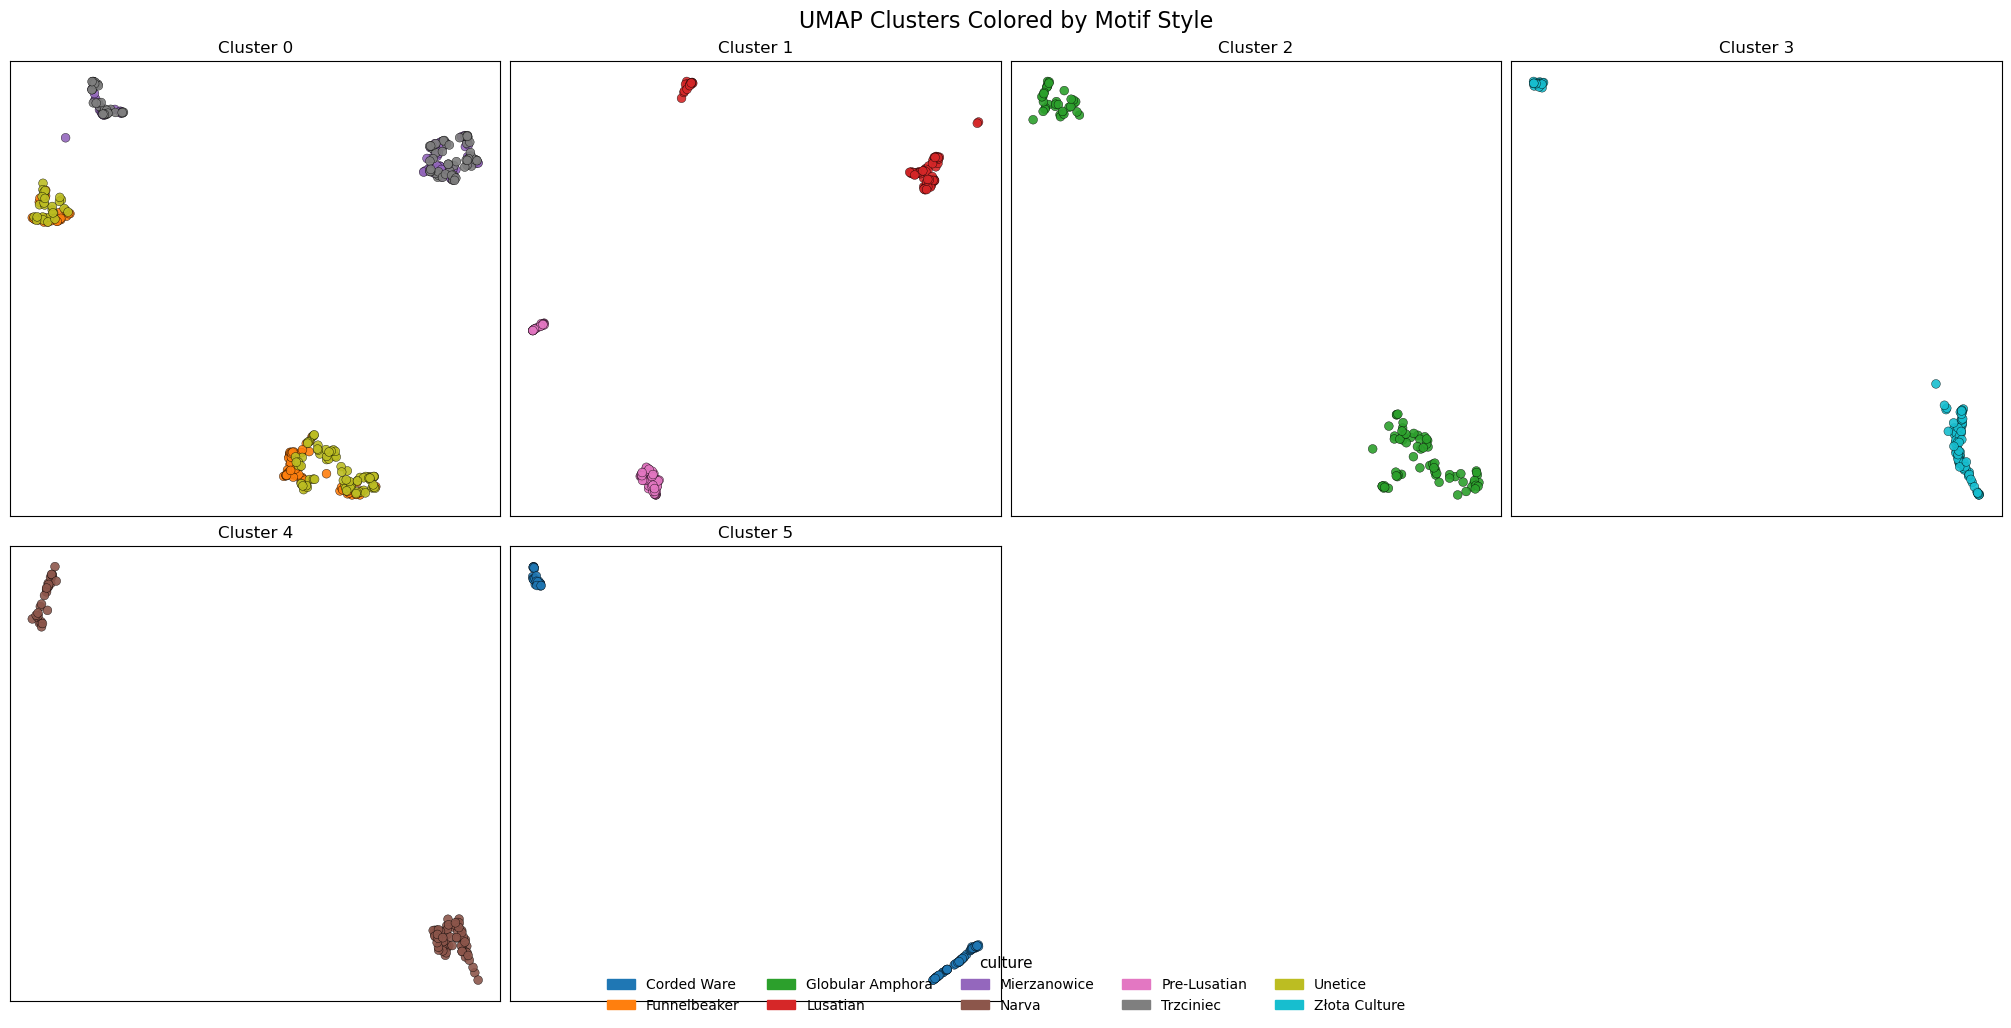

In [ ]:
plot_umap_per_cluster_grid(df,
                           style_col="culture",
                           save_path=os.path.join(DATA_DIR, "umap_clusters_grid_culture_legend.png"))

In [30]:
# === Export Results
df.to_csv(OUTPUT_FEATURES_CSV, index=False)
print(f"✅ Pipeline complete. Features saved to: {OUTPUT_FEATURES_CSV}")

✅ Pipeline complete. Features saved to: synthetic_motifs/augmented\features_with_clusters.csv
